## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from snprop import survey
from variaIa import tools_ar
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond",
    "axes.labelsize": 'x-large',
    "xtick.labelsize": 'x-large',
    "ytick.labelsize": 'x-large'})
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools_ar.cons, su=tools_ar.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'LOWZ': (1, 0, 0, 1),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_SNF = df_nc[df_nc['survey'] == 'SNF']
df_all = df_nc[df_nc['hostmass'] > 7]
# df_LOWZ = df_nc[df_nc['survey'] == 'LOWZ']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', index…

### Use SED fitted SNf data

In [3]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sed = sed.loc[sed['name'].str.contains('SNF|LSQ|PTF', na=False, regex=True)]
sed = sed.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sed['hostmass_err'] = np.sqrt((sed['mass_uppererr']**2 +
                               sed['mass_lowerr']**2)/2)
sedsnf_df = df_nc.loc[df_nc['survey'] == 'SNF'].copy()
sedsnf_df['hostmass'] = sed['hostmass'].values
sedsnf_df['hostmass_err'] = sed['hostmass_err'].values
sedsnf_df_nonan = sedsnf_df.loc[~np.isnan(sedsnf_df['hostmass'])]

In [4]:
df_fit = pd.concat([sedsnf_df_nonan,
                    df_nc[df_nc['survey'] != 'SNF']])
df_fit = df_fit.loc[df_fit['hostmass'] > 7]
df_snf = df_nc.loc[df_nc['survey'] == 'SNF']

### Compare SNF SED masses to LOWZ

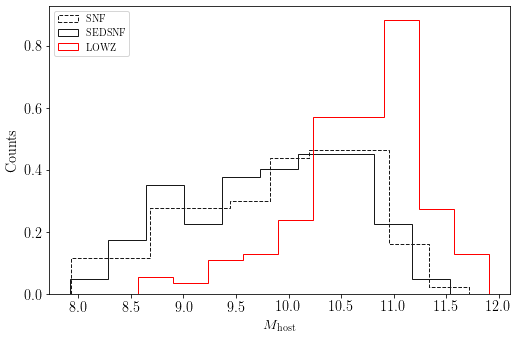

In [33]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.hist(df_SNF['hostmass'],
        color=colors['SNF'], histtype='step', ls='--',
        density=True, label='SNF')
ax.hist(sedsnf_df_nonan['hostmass'],
        color=colors['SNF'], histtype='step',
        density=True, label='SEDSNF')
ax.hist(df_LOWZ.loc[df_LOWZ['hostmass'] > 7.3]['hostmass'],
        color=colors['LOWZ'], histtype='step',
        density=True, label='LOWZ')

# ax.axhline(0, color='k', lw=1, ls='-')
# ax.axvline(10.0, color='k', lw=1, ls='--')

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel('Counts', fontsize='x-large')

ax.tick_params(labelsize='x-large')

ax.legend()

fig.savefig('../../../Images/pdf/mass_hists-SNFvLOWZ.pdf', bbox_inches='tight')

## Use of `massevol` to determine a mass/age relationship

#### SED SNF only

In [5]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
evol4G4M4S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol3G3M4S')
evol3G3M4S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S_sed_SNF = gen.fit(sedsnf_df_nonan, limits=None)

gen.set_model('Evol2G2M4S')
evol2G2M4S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol2G2M3S')
evol2G2M3S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol2G2M2S')
evol2G2M2S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol1G1M2S')
evol1G1M2S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol1G1M1S')
evol1G1M1S_sed_SNF = gen.fit(sedsnf_df_nonan)

mod_list_sed_SNF = [evol1G1M1S_sed_SNF, evol1G1M2S_sed_SNF,
                    evol2G2M2S_sed_SNF, evol2G2M3S_sed_SNF, evol2G2M4S_sed_SNF,
                    evol3G3M3S_sed_SNF, evol3G3M4S_sed_SNF, evol4G4M4S_sed_SNF]
mod_name_sed_SNF = [mod.__doc__ for mod in mod_list_sed_SNF]

pp = PrettyPrinter()
for mod in mod_list_sed_SNF:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:964: RuntimeWarning: invalid value encountered in log
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:1014: RuntimeWarning: invalid value encountered in log


1G1M1S
{'mu': 9.82187625727687, 'sigma': 0.7456061858846675}
1G1M2S
{'mu': 10.193756826776514,
 'sigmadown': 0.9740459068452918,
 'sigmaup': 0.48906638413209524}
Howell
{'mu_1': 9.322332741309046,
 'mu_2': 10.341604804912228,
 'sigma_1': 0.5819364808339831,
 'sigma_2': 0.5095830448317993}
Howell+asym
{'mu': 10.556195468543386,
 'mu_1': 9.336563693969463,
 'sigma_1': -0.5837492861739749,
 'sigmadown': 0.7034737417633242,
 'sigmaup': 0.34260144939104675}
Howell asym
{'mu_o': 10.552824485385461,
 'mu_y': 9.246455657695117,
 'sigmad_o': 0.6988790365588977,
 'sigmad_y': 0.5272525118519866,
 'sigmau_o': 0.343872906242419,
 'sigmau_y': -0.645576679335592}
3G3M3S
{'a': 1976713.6519364933,
 'mu_1': 9.293719881514077,
 'mu_2': 41141.518959834066,
 'mu_3': -10498923.417116333,
 'sigma_1': -0.5021938337346258,
 'sigma_2': -133585.54201765225,
 'sigma_3': 126319257.14592396}
3G3M4S
{'a': 0.6218034630568389,
 'mu': 10.347660855820127,
 'mu_1': 9.342007253050884,
 'mu_2': 10.581935143253347,
 'sigma_

Howell
110
Howell+asym
110
Howell asym
110


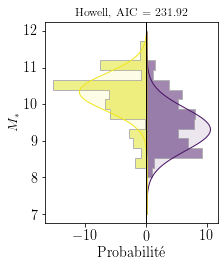

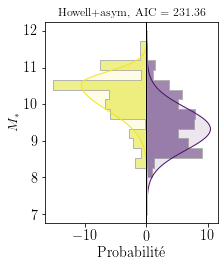

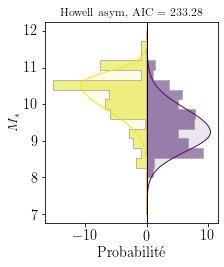

In [13]:
# for name, model in zip(mod_name_sed_SNF[:2], mod_list_sed_SNF[:2]):
#     fig = plt.figure(figsize=[7, 3.5], facecolor='w')
#     ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#     
#     print(name)
#     model.show_model_tot(ax=ax)
#     plt.title(model.__doc__)
#     # plt.close()
#     # 
#     # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_SED-nonan_all.pdf',
#     #             bbox_inches='tight')
#     # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_SED-nonan_all.png',
#     #             bbox_inches='tight', dpi=600)
    
# for name, model in zip(mod_name_sed_SNF[2:-3], mod_list_sed_SNF[2:-3]):
for name, model in zip(mod_name_sed_SNF[2:-3], mod_list_sed_SNF[2:-3]):
    fig = plt.figure(figsize=[3, 3.5], facecolor='w')
    # ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
    print(name)
    print(len(model.pd))
    # gen.set_model(name)
    # mod = gen.model(snf_sed_nonan)
    # mod.param = model.param
    # model.scatter(ax=ax, model=False)
    model.show_hist(ax=axh, bins=15, yotext=False)
    model.show_model(ax=axh,
                     rotate=True, legend=False,
                     o_factor=-model.amp*np.sum(1-model.py),
                     y_factor=model.amp*np.sum(model.py), 
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    # axh.set_ylim(*ax.get_ylim())
    # axh.set_yticks([])
    # axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    # axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__ + f', AIC = {model.get_aic():.2f}')
    # plt.close()
# 
    # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_histonly_SED_SNF-nonan.pdf',
    #             bbox_inches='tight')
    # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_histonly_SED_SNF-nonan.png',
    #             bbox_inches='tight', dpi=600)

## Plot fraction of y as a function of mass

Text(0.5, 1.0, 'SED SNF')

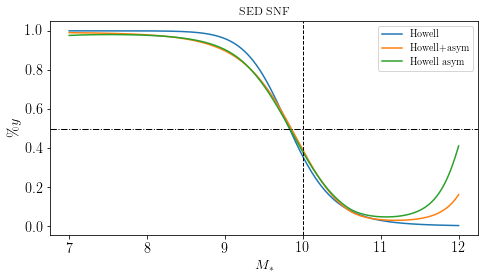

In [7]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name in zip(mod_list_sed_SNF[2:-3], mod_name_sed_SNF[2:-3]):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, label=name)

ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_*$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('SED SNF')

# fig.savefig('../../../Images/pdf/model_mass_yfrac-sed_snf.pdf', bbox_inches='tight')

#### Best SED SNF model

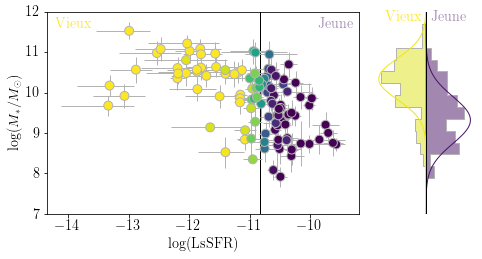

In [97]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])

evol2G2M2S_sed_SNF.scatter(ax, axh, show_leg=False, bins=17)
ax.set_ylabel(r'$\log(M_*/M_{\odot})$')

# plt.close()

fig.savefig('../../../Images/pdf/model_mass_' +
            evol2G2M2S_sed_SNF.__doc__ +
            '_hist_SED-nonan.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/model_mass_' +
            evol2G2M2S_sed_SNF.__doc__ +
            '_hist_SED-nonan.png',
            bbox_inches='tight', dpi=600)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Asymmetric Howell')

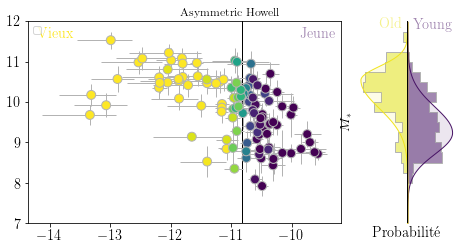

In [41]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])

evol2G2M4S_sed_SNF.scatter(ax=ax, model=False)
evol2G2M4S_sed_SNF.show_hist(ax=axh, bins=16)
evol2G2M4S_sed_SNF.show_model(ax=axh, rotate=True, legend=False,
                 o_factor=-evol2G2M4S_sed_SNF.amp*np.sum(1-evol2G2M4S_sed_SNF.py),
                 y_factor=evol2G2M4S_sed_SNF.amp*np.sum(evol2G2M4S_sed_SNF.py),
                 # facealpha=0,
                 # edgealpha=1,
                 lw=1, zorder=8)

axh.set_ylim(*ax.get_ylim())
axh.set_yticks([])
axh.set_xticks([])

axh.axvline(0, color='k', lw=1, zorder=10)

axh.set_frame_on(False)

plt.suptitle('Asymmetric Howell')
# plt.close()

# fig.savefig('../../../Images/pdf/model_mass_' + evol2G2M4S.__doc__ + '_hist_SED-nonan.pdf',
#             bbox_inches='tight')
# fig.savefig('../../../Images/png/model_mass_' + evol2G2M4S.__doc__ + '_hist_SED-nonan.png',
#             bbox_inches='tight', dpi=600)

#### SNF only

In [6]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
evol4G4M4S_SNF = gen.fit(df_snf)

gen.set_model('Evol3G3M4S')
evol3G3M4S_SNF = gen.fit(df_snf)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S_SNF = gen.fit(df_snf, limits=None)

gen.set_model('Evol2G2M4S')
evol2G2M4S_SNF = gen.fit(df_snf)

gen.set_model('Evol2G2M3S')
evol2G2M3S_SNF = gen.fit(df_snf)

gen.set_model('Evol2G2M2S')
evol2G2M2S_SNF = gen.fit(df_snf)

gen.set_model('Evol1G1M2S')
evol1G1M2S_SNF = gen.fit(df_snf)

gen.set_model('Evol1G1M1S')
evol1G1M1S_SNF = gen.fit(df_snf)

mod_list_SNF = [evol1G1M1S_SNF, evol1G1M2S_SNF,
                evol2G2M2S_SNF, evol2G2M3S_SNF, evol2G2M4S_SNF,
                evol3G3M3S_SNF, evol3G3M4S_SNF, evol4G4M4S_SNF]
mod_name_SNF = [mod.__doc__ for mod in mod_list_SNF]

pp = PrettyPrinter()
for mod in mod_list_SNF:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1G1M1S
{'mu': 9.899600471027695, 'sigma': 0.8166446199117832}
1G1M2S
{'mu': 10.495397752090653,
 'sigmadown': 1.1581100938321138,
 'sigmaup': 0.41670747797498214}
Howell
{'mu_1': 9.355305744812112,
 'mu_2': 10.582100892823973,
 'sigma_1': 0.6433441309399807,
 'sigma_2': -0.3839343925296697}
Howell+asym
{'mu': 10.676200755120735,
 'mu_1': 9.368589263375236,
 'sigma_1': -0.6535418633612555,
 'sigmadown': 0.5400370303603267,
 'sigmaup': 0.34913561285685973}
Howell asym
{'mu_o': 10.683466927082339,
 'mu_y': 9.469159807651781,
 'sigmad_o': 0.5534234596133718,
 'sigmad_y': 0.7136947945293897,
 'sigmau_o': 0.3468395051932665,
 'sigmau_y': 0.5924136828861535}
3G3M3S
{'a': 0.9025777523038084,
 'mu_1': 9.42426512116249,
 'mu_2': 10.59297892851153,
 'mu_3': 8.744824893848087,
 'sigma_1': 0.6350972666001241,
 'sigma_2': 0.373869507483945,
 'sigma_3': 0.42851250949106007}
3G3M4S
{'a': 2.42953408801679,
 'mu': 11.031865368893449,
 'mu_1': 9.35731270646204,
 'mu_2': 9.277746020971291,
 'sigma_1': 0.5

Howell
114
Howell+asym
114
Howell asym
114


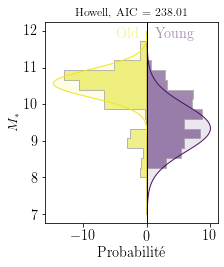

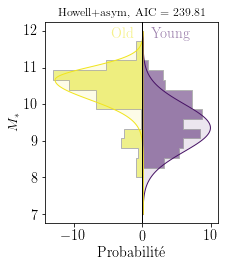

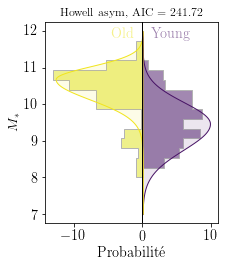

In [11]:
# for name, model in zip(mod_name_SNF[:2], mod_list_SNF[:2]):
#     fig = plt.figure(figsize=[7, 3.5], facecolor='w')
#     ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#     
#     print(name)
#     model.show_model_tot(ax=ax)
#     plt.title(model.__doc__)
#     # plt.close()
#     # 
#     # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '-nonan_all.pdf',
#     #             bbox_inches='tight')
#     # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '-nonan_all.png',
#     #             bbox_inches='tight', dpi=600)
    
for name, model in zip(mod_name_SNF[2:-3], mod_list_SNF[2:-3]):
    fig = plt.figure(figsize=[3, 3.5], facecolor='w')
    #ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.10, 0.12, 0.8, 0.8])
 
    print(name)
    print(len(model.pd))
    # gen.set_model(name)
    # mod = gen.model(snf_nonan)
    # mod.param = model.param
    # model.scatter(ax=ax, model=False)
    model.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh, rotate=True, legend=False,
                     o_factor=-model.amp*np.sum(1-model.py),
                     y_factor=model.amp*np.sum(model.py),
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    # axh.set_ylim(*ax.get_ylim())
    # axh.set_yticks([])
    # axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    # axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__ + f', AIC = {model.get_aic():.2f}')
    # plt.close()
# 
    # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_histonly_SNF.pdf',
    #             bbox_inches='tight')
    # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_histonly_SNF.png',
    #             bbox_inches='tight', dpi=600)

Text(0.5, 1.0, 'SNF')

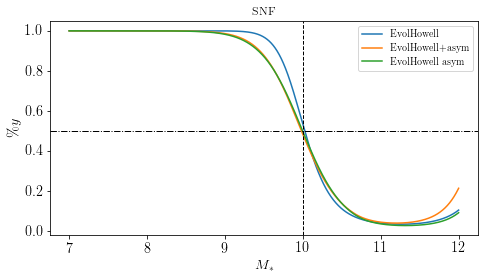

In [9]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name in zip(mod_list_SNF[2:-3], mod_name_SNF[2:-3]):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, label=name)
    
# mod = mod_list_SNF[-1]
# name = mod_name_SNF[-1]
# Mlin = np.linspace(mod.floor, mod.ceil, 3000)
# l_y = mod.plot_y(Mlin)
# l_o = mod.plot_o(Mlin)
# yo = l_y/(l_y+l_o)
# ax.plot(Mlin, yo, label=name)

ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_*$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('SNF')

# fig.savefig('../../../Images/pdf/model_mass_yfrac-snf.pdf', bbox_inches='tight')

#### All samples combined with SED SNF

In [7]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, (5, 15), (-1, 1)]
evol3G3M3S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S_sed = gen.fit(df_fit, limits=None)

mod_list_sed = [evol1G1M1S_sed, evol1G1M2S_sed,
                evol2G2M2S_sed, evol2G2M3S_sed, evol2G2M4S_sed,
                evol3G3M3S_sed, evol3G3M4S_sed, evol4G4M4S_sed]
mod_name_sed = [mod.__doc__ for mod in mod_list_sed]

pp = PrettyPrinter()
for mod in mod_list_sed:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.11596049193267, 'sigma': 0.7999054049383606}
1G1M2S
{'mu': 10.537053905997043,
 'sigmadown': 1.0578654652930064,
 'sigmaup': 0.5270579677127994}
Howell
{'mu_1': 9.62642956347428,
 'mu_2': 10.72986062488843,
 'sigma_1': 0.7026103217942373,
 'sigma_2': -0.4282028272333765}
Howell+asym
{'mu': 10.803467578038184,
 'mu_1': 9.645823606766768,
 'sigma_1': 0.7171798263930571,
 'sigmadown': -0.5210929405781122,
 'sigmaup': 0.39183090816099775}
Howell asym
{'mu_o': 10.738512811711528,
 'mu_y': 9.340547224392175,
 'sigmad_o': 0.493226176019227,
 'sigmad_y': 0.5184903014935405,
 'sigmau_o': 0.4067547467988055,
 'sigmau_y': 0.9602041454268972}
3G3M3S
{'a': 0.9436836617435239,
 'mu_1': 9.697674818505337,
 'mu_2': 10.733763966183679,
 'mu_3': 9.12774986155939,
 'sigma_1': 0.7334754770671146,
 'sigma_2': 0.41828274066337995,
 'sigma_3': -4.0571971230101e-06}
3G3M4S
{'a': 0.8485074700256083,
 'mu': 9.087099414131357,
 'mu_1': 9.716592988438087,
 'mu_2': 10.775313548385725,
 'sigma_1': 

Howell
544
Howell+asym
544
Howell asym
544


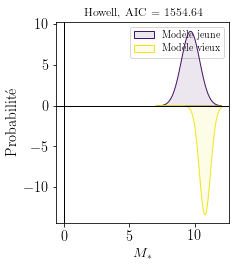

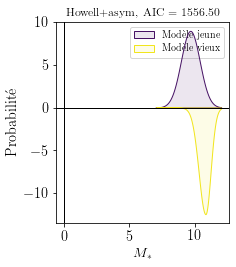

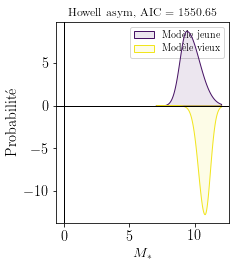

In [14]:
# for name, model in zip(mod_name_sed[:2], mod_list_sed[:2]):
#     fig = plt.figure(figsize=[7, 3.5], facecolor='w')
#     ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#     
#     print(name)
#     model.show_model_tot(ax=ax)
#     plt.title(model.__doc__)
#     # plt.close()
#     # 
#     # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_SED-nonan_all.pdf',
#     #             bbox_inches='tight')
#     # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_SED-nonan_all.png',
#     #             bbox_inches='tight', dpi=600)
    
for name, model, hist in zip(mod_name_sed[2:-3], mod_list_sed[2:-3], mod_list_SNF[2:-3]):
    fig = plt.figure(figsize=[3, 3.5], facecolor='w')
    # ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
    print(name)
    print(len(model.pd))
    # gen.set_model(name)
    # mod = gen.model(snf_sed_nonan)
    # mod.param = model.param
    # model.scatter(ax=ax, model=False)
    # hist.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh,
                     o_factor=-hist.amp*np.sum(1-hist.py),
                     y_factor=hist.amp*np.sum(hist.py),
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    # axh.set_ylim(*ax.get_ylim())
    # axh.set_yticks([])
    # axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    # axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__ + f', AIC = {model.get_aic():.2f}')
    # plt.close()
# 
    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_histonly_SED_ALL-nonan.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_histonly_SED_ALL-nonan.png',
                bbox_inches='tight', dpi=600)

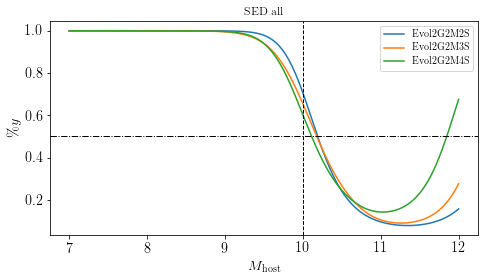

In [14]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name in zip(mod_list_sed[2:-3], mod_name_sed[2:-3]):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, label=name)

ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('SED all')

fig.savefig('../../../Images/pdf/model_mass_yfrac-sed_all.pdf', bbox_inches='tight')

#### All samples combined with SNF

In [8]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S = gen.fit(df_all, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S = gen.fit(df_all, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, (5, 15), (-1, 1)]
evol3G3M3S = gen.fit(df_all, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S = gen.fit(df_all, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(df_all, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(df_all, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(df_all, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(df_all, limits=None)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = [mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.124465562050489, 'sigma': 0.8100453331311093}
1G1M2S
{'mu': 10.632604419068128,
 'sigmadown': 1.1126306086852333,
 'sigmaup': 0.4736546335237936}
Howell
{'mu_1': 9.627026021103038,
 'mu_2': 10.759094543713362,
 'sigma_1': 0.7068326795242196,
 'sigma_2': 0.4040050078626721}
Howell+asym
{'mu': 10.747662997852716,
 'mu_1': 9.626318236068037,
 'sigma_1': 0.7064476678930907,
 'sigmadown': -0.39465497903381275,
 'sigmaup': 0.41038959172488887}
Howell asym
{'mu_o': 10.71857855997824,
 'mu_y': 9.421361020415352,
 'sigmad_o': 0.3936187900875556,
 'sigmad_y': 0.5821327334028682,
 'sigmau_o': 0.4143439546648749,
 'sigmau_y': 0.879467319176058}
3G3M3S
{'a': 0.954138753827836,
 'mu_1': 9.685182485055902,
 'mu_2': 10.76271300702342,
 'mu_3': 8.902440018343414,
 'sigma_1': 0.7170421488121282,
 'sigma_2': 0.40010593777690606,
 'sigma_3': 0.39918931583723694}
3G3M4S
{'a': 0.04584885164026587,
 'mu': 10.74632039017547,
 'mu_1': 9.684298736587458,
 'mu_2': 8.904452620246662,
 'sigma_1': 

Howell
548
Howell+asym
548
Howell asym
548


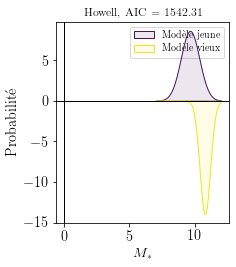

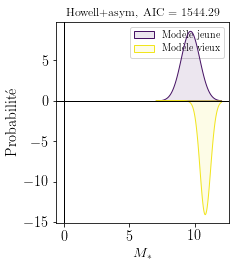

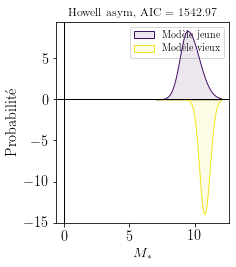

In [21]:
# for name, model in zip(mod_name[:2], mod_list[:2]):
#     fig = plt.figure(figsize=[7, 3.5], facecolor='w')
#     ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#     
#     print(name)
#     model.show_model_tot(ax=ax)
#     plt.title(model.__doc__)
#     # plt.close()
#     # 
#     # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '-nonan_all.pdf',
#     #             bbox_inches='tight')
#     # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '-nonan_all.png',
#     #             bbox_inches='tight', dpi=600)
    
for name, model, hist in zip(mod_name[2:-3], mod_list[2:-3], mod_list_sed_SNF[2:-3]):
    fig = plt.figure(figsize=[3, 3.5], facecolor='w')
    # ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
    print(name)
    print(len(model.pd))
    # gen.set_model(name)
    # mod = gen.model(snf_nonan)
    # mod.param = model.param
    # model.scatter(ax=ax, model=False)
    # hist.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh,
                     o_factor=-hist.amp*np.sum(1-hist.py),
                     y_factor=hist.amp*np.sum(hist.py),
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    # axh.set_ylim(*ax.get_ylim())
    # axh.set_yticks([])
    # axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    #axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__ + f', AIC = {model.get_aic():.2f}')
    # plt.close()
# 
    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_histonly_ALL.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_histonly_ALL.png',
                bbox_inches='tight', dpi=600)

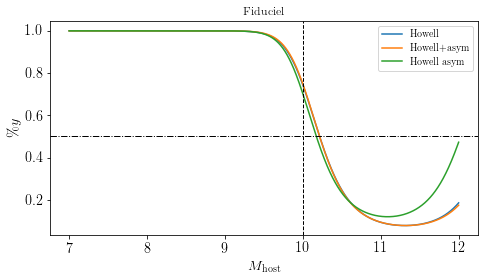

In [23]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name in zip(mod_list[2:-3], mod_name[2:-3]):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, label=name)

ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('Fiduciel')

fig.savefig('../../../Images/pdf/model_mass_yfrac-all.pdf', bbox_inches='tight')

## Plot the 3 best yfrac

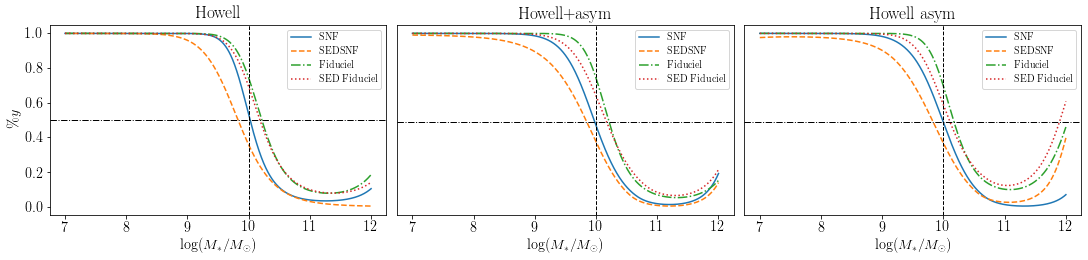

In [21]:
# fig = plt.figure(figsize=[5, 3.5], facecolor='w')
# ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

# sedsnf_df_nonan['MBIN'] = pd.cut(sedsnf_df_nonan['hostmass'], 10)
# list_bins = np.unique(sedsnf_df_nonan['MBIN'])
# cbin_hl = [(binn.left + binn.right)/2 for binn in list_bins]
# yfrac_hl = []
# 
# for binn in list_bins:
#     temp_lib = sedsnf_df_nonan.loc[(sedsnf_df_nonan['hostmass'] > binn.left) &
#                            (sedsnf_df_nonan['hostmass'] <= binn.right)]
#     # num_o = temp_lib.loc[temp_lib['py'] < 0.5]
#     # num_y = temp_lib.loc[temp_lib['py'] >= 0.5]
#     num_o = temp_lib.loc[temp_lib['lssfr'] < -10.82]
#     num_y = temp_lib.loc[temp_lib['lssfr'] > -10.82]
#     yfrac_hl.append(len(num_y)/(len(num_o)+len(num_y)))

fig = plt.figure(figsize=[15, 3.5], constrained_layout=True)
gs = fig.add_gridspec(1, 3)
axd = gs.subplots(sharex='col')
num_mod = [2, 3, 4]
titles = ['Howell', 'Howell+asym', 'Howell asym']
for i, ax in enumerate(axd):
    for mod, name, ls in zip([mod_list_SNF[num_mod[i]],
                              mod_list_sed_SNF[num_mod[i]],
                              mod_list[num_mod[i]],
                              mod_list_sed[num_mod[i]]],
                             ['SNF', 'SEDSNF', 'Fiduciel', 'SED Fiduciel'],
                             ['-', '--', '-.', ':']):
        Mlin = np.linspace(mod.floor, 12, 3000)
        l_y = mod.plot_y(Mlin)
        l_o = mod.plot_o(Mlin)
        yo = l_y/(l_y+l_o)
        ax.plot(Mlin, yo, ls=ls,
                label=name)
    ax.axhline(0.5, ls='-.', color='k', lw=1)
    ax.axvline(10.0, ls='--', color='k', lw=1)
    
    ax.set_xlabel(r'$\log(M_*/M_{\odot})$', fontsize='x-large')
    if i < 1:
        ax.set_ylabel(r'$\%y$', fontsize='x-large')
        # ax.scatter(cbin_hl, yfrac_hl,
        #            marker='d',
        #            edgecolors='0.3', color='C1',
        #            label=r'Données')
    if i >= 1:
        ax.set_yticks([])
    ax.tick_params(labelsize='x-large')
    
    ax.legend()
    ax.set_title(titles[i], fontsize='xx-large')

fig.savefig('../../../Images/pdf/model_mass_yfrac-best.pdf', bbox_inches='tight')

### Plot mean mass

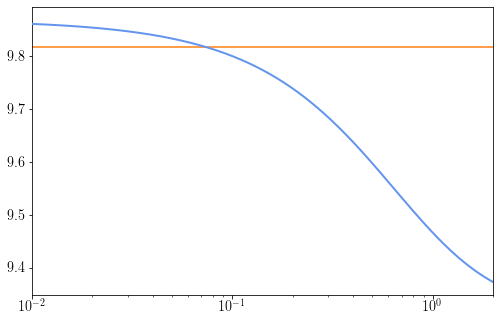

In [111]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

zlin = np.linspace(0.00001, 2, 3000)

ax.plot(zlin, evol2G2M2S_sed_SNF.plot_evol(zlin),
        color="cornflowerblue", lw=2,
        label='Howell SNF', zorder=8)

ax.axhline(np.mean(sedsnf_df_nonan['hostmass']), color='C1')

# ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 2)
ax.set_xscale('log')

### Plot all model_evol

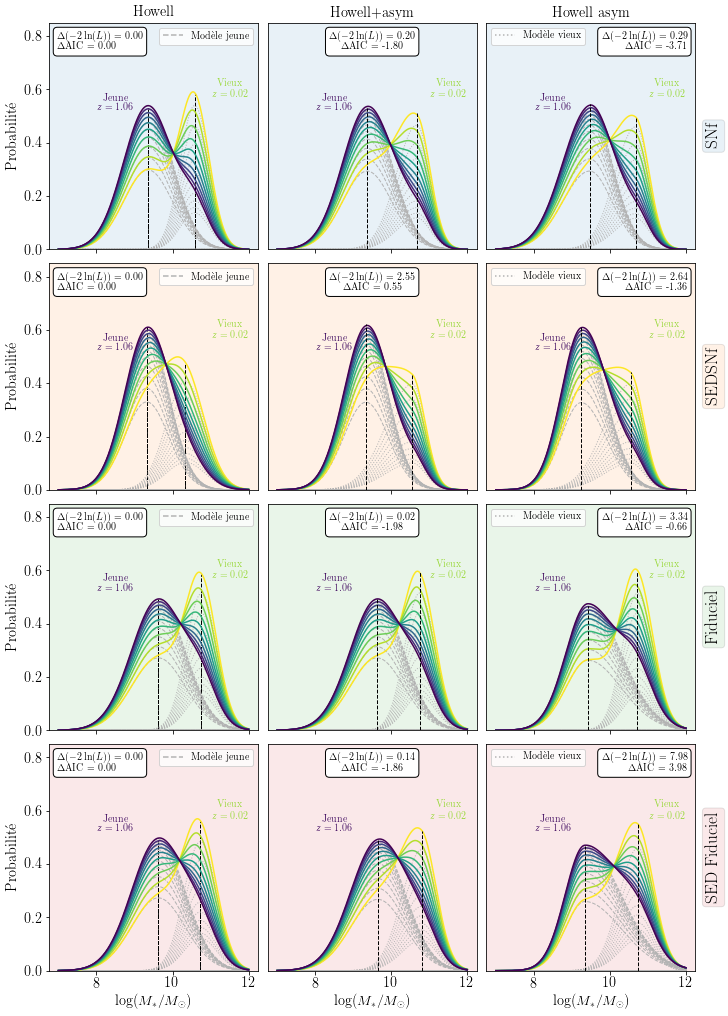

In [95]:
fig = plt.figure(figsize=[10, 14], constrained_layout=True)
gs = fig.add_gridspec(4, 3)
axd = gs.subplots(sharex='col')

mod_left = [evol2G2M2S_SNF,
            evol2G2M2S_sed_SNF,
            evol2G2M2S,
            evol2G2M2S_sed]
z = np.mean(df_nc.redshifts)
zlin = np.linspace(df_nc.redshifts.min(),
                   np.max(df_full.loc[df_full['survey'] == 'SNLS'].redshifts), 10)
mod_prop = [{}, {}, {}, {}]

mod_cent = [evol2G2M3S_SNF,
            evol2G2M3S_sed_SNF,
            evol2G2M3S,
            evol2G2M3S_sed]
max_cent = {'y': [0.625, 0.73, 0.58, 0.58],
            'o': [0.60, 0.51, 0.70, 0.615]}

mod_righ = [evol2G2M4S_SNF,
            evol2G2M4S_sed_SNF,
            evol2G2M4S,
            evol2G2M4S_sed]
max_righ = {'y': [0.64, 0.72, 0.55, 0.55],
            'o': [0.58, 0.52, 0.70, 0.65]}

font_dict = {'fontsize': 'medium'}
back_color = ['C0', 'C1', 'C2', 'C3']
samples = ['SNf', 'SEDSNf', 'Fiduciel', 'SED Fiduciel']
box_prop = dict(facecolor='white', boxstyle='round', pad=0.4)#, alpha=0.5)
ymax = []

for i, mod, ax, prop in zip(range(len(mod_left)), mod_left, axd[:,0], mod_prop):
    mod.show_model_evol(ax, cmap='viridis_r', zlin=zlin, **prop)
    for z in zlin:
        mod.show_model(ax,
                       y_factor=mod.delta(z), o_factor=(1-mod.delta(z)),
                       ls_o=':', ls_y='--',
                       edgecolor_o='0.7', edgecolor_y='0.7',
                       facecolor_o='none', facecolor_y='none', legend=False)
    ax.text(11.5, 0.6, f'Vieux\n$z={zlin.min():.2f}$',
            color=plt.cm.viridis(0.85),
            ha='center', va='center',
            **font_dict)
    ax.text(8.5, 0.55, f'Jeune\n$z={zlin.max():.2f}$',
            color=plt.cm.viridis(0.05),
            ha='center', va='center',
            **font_dict)
    s = f'$\Delta(-2\ln(L))$ = {mod_left[i].get_logl()-mod.get_logl():.2f}\n' +\
                f'$\Delta$AIC = {mod_left[i].get_aic()-mod.get_aic():.2f}' 
    ax.text(0.04, 0.96, s,
            ha='left', va='top',
            transform=ax.transAxes,
            **font_dict,
            bbox=box_prop)
    leg_l = ax.legend([Line2D([0], [0], color='0.7', ls='--')],
                      ['Modèle jeune'], loc='upper right', fontsize='medium')
                      #bbox_to_anchor=(-0.1, 1.02, 0.1, 0.1))
    if i < 3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
    if i == 0:
        ax.set_title('Howell', fontsize='x-large')
    ymax.append(ax.get_ylim()[-1])
    ax.patch.set_facecolor(back_color[i])
    ax.patch.set_alpha(0.1)

for i, mod, ax, prop in zip(range(len(mod_cent)), mod_cent, axd[:,1], mod_prop):
    mod.show_model_evol(ax, cmap='viridis_r', zlin=zlin, means=False, **prop)
    Mlin = np.linspace(7, 12, 100)
    for z in zlin:
        mod.show_model(ax,
                       y_factor=mod.delta(z), o_factor=(1-mod.delta(z)),
                       ls_o=':', ls_y='--',
                       edgecolor_o='0.7', edgecolor_y='0.7',
                       facecolor_o='none', facecolor_y='none', legend=False)
    muo = list(mod.pltmo.values())[0]
    muy = list(mod.pltmy.values())[0]
    ax.axvline(list(mod.pltmo.values())[0],
               ymax=max_cent['o'][i],
               ls='--', color='k', lw=1)
    ax.axvline(list(mod.pltmy.values())[0],
               ymax=max_cent['y'][i],
               ls='--', color='k', lw=1)
    ax.text(11.5, 0.6, f'Vieux\n$z={zlin.min():.2f}$',
            color=plt.cm.viridis(0.85),
            ha='center', va='center',
            **font_dict)
    ax.text(8.5, 0.55, f'Jeune\n$z={zlin.max():.2f}$',
            color=plt.cm.viridis(0.05),
            ha='center', va='center',
            **font_dict)
    s = f'$\Delta(-2\ln(L))$ = {mod_left[i].get_logl()-mod.get_logl():.2f}\n' +\
                f'$\Delta$AIC = {mod_left[i].get_aic()-mod.get_aic():.2f}' 
    ax.text(0.50, 0.96, s,
            ha='center', va='top',
            transform=ax.transAxes,
            **font_dict,
            bbox=box_prop)
    ax.set_ylabel('')
    if i < 3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
    if i == 0:
        ax.set_title('Howell+asym', fontsize='x-large')
    ax.set_yticks([])
    ymax.append(ax.get_ylim()[-1])
    ax.patch.set_facecolor(back_color[i])
    ax.patch.set_alpha(0.1)

for i, mod, ax, prop in zip(range(len(mod_righ)), mod_righ, axd[:,-1], mod_prop):
    mod.show_model_evol(ax, cmap='viridis_r', zlin=zlin, means=False, **prop)
    for z in zlin:
        mod.show_model(ax,
                       y_factor=mod.delta(z), o_factor=(1-mod.delta(z)),
                       ls_o=':', ls_y='--',
                       edgecolor_o='0.7', edgecolor_y='0.7',
                       facecolor_o='none', facecolor_y='none', legend=False)
    muo = list(mod.pltmo.values())[0]
    muy = list(mod.pltmy.values())[0]
    ax.axvline(muo,
               ymax=max_righ['o'][i],
               ls='--', color='k', lw=1)
    ax.axvline(muy,
               ymax=max_righ['y'][i],
               ls='--', color='k', lw=1)
    ax.text(11.5, 0.6, f'Vieux\n$z={zlin.min():.2f}$',
            color=plt.cm.viridis(0.85),
            ha='center', va='center',
            **font_dict)
    ax.text(8.5, 0.55, f'Jeune\n$z={zlin.max():.2f}$',
            color=plt.cm.viridis(0.05),
            ha='center', va='center',
            **font_dict)
    s = f'$\Delta(-2\ln(L))$ = {mod_left[i].get_logl()-mod.get_logl():.2f}\n' +\
                f'$\Delta$AIC = {mod_left[i].get_aic()-mod.get_aic():.2f}' 
    ax.text(0.96, 0.96, s,
            ha='right', va='top',
            transform=ax.transAxes,
            **font_dict,
            bbox=box_prop)
    leg_r = ax.legend([Line2D([0], [0], color='0.7', ls=':')],
                      ['Modèle vieux'], loc='upper left', fontsize='medium')
                      # bbox_to_anchor=(-0.1, 1.02, 0.1, 0.1))
    ax.set_ylabel('')
    if i < 3:
        ax.set_xlabel('')
    else:
        ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
    if i == 0:
        ax.set_title('Howell asym', fontsize='x-large')
    ax.set_yticks([])
    ymax.append(ax.get_ylim()[-1])
    ax.text(1.05, 0.5, samples[i],
            ha='left', va='center', 
            transform=ax.transAxes,
            rotation=90,
            fontsize='xx-large',
            bbox=dict(facecolor=back_color[i], boxstyle='round', pad=0.2, alpha=0.1))
    ax.patch.set_facecolor(back_color[i])
    ax.patch.set_alpha(0.1)

for ax in axd.ravel():
    # ax.set_ylim(top=np.max(ymax))
    ax.set_ylim(top=0.85)

fig.savefig(f'../../../Images/pdf/mass_model_all_evol.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/mass_model_all_evol.png', dpi=600)

## Plot pretty?

ValueError: weights should have the same shape as x

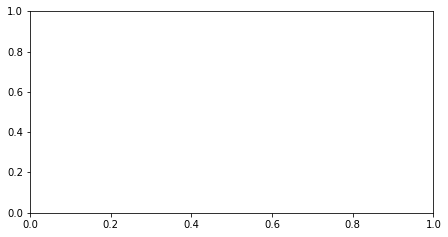

In [10]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
evol3G3M3S.show_hist(ax=ax, bins=15)
evol3G3M3S.show_model(ax=ax,
                 o_factor=-evol3G3M3S.amp*np.sum(1-evol3G3M3S.py),
                 y_factor=evol3G3M3S.amp*np.sum(evol3G3M3S.py),
                 # facealpha=0,
                 # edgealpha=1,
                 lw=1, zorder=8)
 
ax.axvline(0, color='k', lw=1, zorder=10)

#ax.set_xticks([])
ax.set_xlim(-10, 12)
 
ax.set_xlabel(r'$\mathrm{log(LsSFR)}$', fontsize='x-large')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{host}$', fontsize='x-large')

plt.suptitle(evol3G3M3S.__doc__)
 
fig.savefig('../../../Images/pdf/model_mass_' + evol3G3M3S.__doc__ + '_histonly_SED-nonan_all.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/model_mass_' + evol3G3M3S.__doc__ + '_histonly_SED-nonan_all.png',
            bbox_inches='tight', dpi=600)

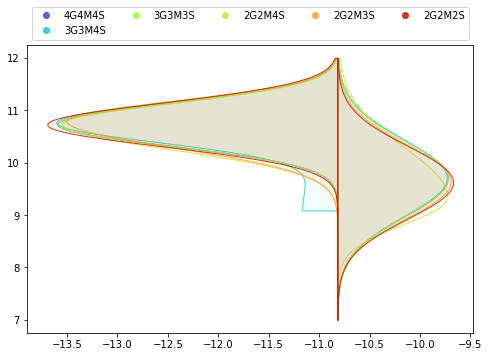

In [15]:
fig = plt.figure(figsize=[10, 5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#evol4G4M4S.scatter(model=False, ax=ax)
#evol4G4M4S.show_hist(ax, yotext=False, alpha=.1)
evol4G4M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.1, 0.05), eco=plt.cm.turbo(0.1, 0.9),
                      fcy=plt.cm.turbo(0.1, 0.05), ecy=plt.cm.turbo(0.1, 0.9))
                      #o_factor=-evol4G4M4S.amp*np.sum(1-evol4G4M4S.py),
                      #y_factor=evol4G4M4S.amp*np.sum(evol4G4M4S.py))
#evol3G3M4S.show_hist(ax, yotext=False, alpha=0)
evol3G3M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.3, 0.05), eco=plt.cm.turbo(0.3, 0.9),
                      fcy=plt.cm.turbo(0.3, 0.05), ecy=plt.cm.turbo(0.3, 0.9))
                      #o_factor=-evol3G3M4S.amp*np.sum(1-evol3G3M4S.py),
                      #y_factor=evol3G3M4S.amp*np.sum(evol3G3M4S.py))
#evol3G3M3S.show_hist(ax, yotext=False, alpha=0)
evol3G3M3S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.5, 0.05), eco=plt.cm.turbo(0.5, 0.9),
                      fcy=plt.cm.turbo(0.5, 0.05), ecy=plt.cm.turbo(0.5, 0.9))
                      #o_factor=-evol3G3M3S.amp*np.sum(1-evol3G3M3S.py),
                      #y_factor=evol3G3M3S.amp*np.sum(evol3G3M3S.py))
evol2G2M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.6, 0.05), eco=plt.cm.turbo(0.6, 0.9),
                      fcy=plt.cm.turbo(0.6, 0.05), ecy=plt.cm.turbo(0.6, 0.9))
#evol2G2M3S.show_hist(ax, yotext=False, alpha=0)
evol2G2M3S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.7, 0.05), eco=plt.cm.turbo(0.7, 0.9),
                      fcy=plt.cm.turbo(0.7, 0.05), ecy=plt.cm.turbo(0.7, 0.9))
                      #o_factor=-evol2G2M3S.amp*np.sum(1-evol2G2M3S.py),
                      #y_factor=evol2G2M3S.amp*np.sum(evol2G2M3S.py))
#evol2G2M2S.show_hist(ax, yotext=False, alpha=0)
evol2G2M2S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.9, 0.05), eco=plt.cm.turbo(0.9, 0.9),
                      fcy=plt.cm.turbo(0.9, 0.05), ecy=plt.cm.turbo(0.9, 0.9))
                      #o_factor=-evol2G2M2S.amp*np.sum(1-evol2G2M2S.py),
                      #y_factor=evol2G2M2S.amp*np.sum(evol2G2M2S.py))

from matplotlib.lines import Line2D

evol4G4M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.1,0.9), linewidth=0)
evol3G3M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.3,0.9), linewidth=0)
evol3G3M3Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.5,0.9), linewidth=0)
evol2G2M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.6,0.9), linewidth=0)
evol2G2M3Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.7,0.9), linewidth=0)
evol2G2M2Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.9,0.9), linewidth=0)
handles = [evol4G4M4Sleg, evol3G3M4Sleg, evol3G3M3Sleg,
           evol2G2M4Sleg, evol2G2M3Sleg, evol2G2M2Sleg]
labels = ['4G4M4S', '3G3M4S', '3G3M3S', '2G2M4S', '2G2M3S', '2G2M2S']

ax.legend(handles, labels,
          loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))

fig.savefig('../../../Images/pdf/models_mass_hist_SED-nonan_all.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/models_mass_hist_SED-nonan_all.png',
            bbox_inches='tight', dpi=600)

### Weird masses to Mat

In [9]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
#sed[(sed['mass'] > 8.2) &
#    (sed['mass'] < 9.)].to_csv('../../../Data/mass/weird_sedsnf.csv', sep=' ')

### Lowz masses to Mat

In [10]:
d = pd.read_csv('../../../Data/sne/data_cheat.csv', sep=' ', index_col='CID')
lowz_df = d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])]
#lowz_df.to_csv('../../../Data/sne/lowz.csv', sep=' ')